In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = -1

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
output_path = study_path+"/user/fast_fi00"

In [6]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

In [45]:
S = 52
NTrain = 1
H = 168

In [13]:
def create_weekly_problem(k,s,pen_low,pen_high,output_path,reservoir):
    model = retrieve_problem(k+1,s+1,output_path)
    model.controls.xslp_log = -1

    # STATE
    x_s = xp.var("x_s",lb = 0, ub = reservoir.capacity)
    model.addVariable (x_s)          # State at the begining of the current week

    x_s_1 = xp.var("x_s_1",lb = 0, ub = reservoir.capacity)
    model.addVariable (x_s_1) # State at the begining of the following week

    q = [xp.var(f"q_{i}",lb = float('-inf'), ub =  float('inf')) for i in range(H+1)]
    model.addVariable (q)               # Level of stock at each hour

    # CONTROLS
    # Battery (<0 : pompage)
    r = [xp.var(f"r_{i}",lb = -reservoir.P_pump[7*s]*reservoir.efficiency, ub =  reservoir.P_turb[7*s]) for i in range(H)]

    model.addVariable (r)           # Charge and discharge control for the battery: r<0 means charge 
    R = xp.var()
    model.addVariable(R)                         

    z = xp.var("z",lb = float('-inf'), ub =  float('inf'))

    model.addVariable (z) # Auxiliar variable to introduce the piecewise representation of the future cost
    y = xp.var("y")

    model.addVariable (y)    # Penality for violating guide curves


    # Battery dynamics
    model.addConstraint(q[0] == x_s)                           # State of the current week equal to the initial stock of the reservoir for the week
    model.addConstraint(q[H] == x_s_1)                          # State of the following week equal to the resulting level of stock for begining of the following week

    for h in range(H):
        model.addConstraint(q[h+1] == q[h] - r[h] + reservoir.inflow[s,k])               # Stock evolution equation
    model.addConstraint(R == xp.Sum([r[h] for h in range(H)]))
    
    model.addConstraint(y >=  -pen_low* (x_s_1 - reservoir.Xmin[s]))
    model.addConstraint(y >=  pen_high* (x_s_1 - reservoir.Xmax[s]))

    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

    model.chgmcoef(binding_id,[R],[-1])
    model.chgrhs(binding_id,[0])

    model.chgobj([y,z], [1,1])
    return([model,z,x_s,x_s_1,R, binding_id])
    

In [31]:
def solve_weekly_problem(model,z,x_s,x_s_1,R,binding_id,x0, Vj):
    nb_cons = model.attributes.rows
    model.addConstraint(z >= Vj[0] * x_s_1 + Vj[1])

    # model.addConstraint(x_s_1==xf)

    cst_initial_level = x_s == x0
    model.addConstraint(cst_initial_level)
    model.lpoptimize()

    

    if model.attributes.lpstatus==1:
        beta = model.getObjVal()
        lamb = model.getDual(cst_initial_level)
        z = model.getSolution(z)
        u = model.getSolution(R)
        mu = model.getDual(binding_id)[0]
        model.delConstraint(range(nb_cons+1,model.attributes.rows))
        return(beta,lamb,z,u,mu,model.attributes.SIMPLEXITER)
    else :
        raise(ValueError)

In [43]:
def compute_x(reservoir,X,U,V,reward,pen_low,pen_high):
    initial_x = [reservoir.initial_level]
    k = 0
    cout_tot = 0

    for s in range(S):
        cout = 0
        V_fut = lambda x: min([-V[i][s+1,0]*x-V[i][s+1,1] for i in range(len(V))])
        pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
        Gs = lambda x: min([reward[i][s,0]*x+reward[i][s,1] for i in range(len(reward))])

        Vu = float('-inf')

        for i_fut in range(len(X[s])):
            u = -X[s][i_fut] + initial_x[-1] + reservoir.inflow[s,k]*H
            if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                G = Gs(u)
                v = V_fut(X[s][i_fut])
                penalty = pen(X[s][i_fut])
                if (G + v+penalty) > Vu:
                    Vu = G + v+penalty
                    xf = X[s][i_fut]
                    cout = G

        for u in range(len(U[s])):
            state_fut = min(reservoir.capacity,initial_x[-1] - U[s][u] + reservoir.inflow[s,k]*H) 
            if 0 <= state_fut :
                penalty = pen(state_fut)
                G = Gs(U[s][u])
                if (G + V_fut(state_fut)+penalty) > Vu:
                    Vu = (G + V_fut(state_fut)+penalty)
                    xf = state_fut
                    cout = G

        Umin = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
        if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umin + reservoir.inflow[s,k]*H
            penalty = pen(state_fut)
            if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umin) + V_fut(state_fut)+penalty
                xf = state_fut
                cout = Gs(Umin)

        Umax = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
        if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umax + reservoir.inflow[s,k]*H 
            penalty = pen(state_fut)
            if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umax) + V_fut(state_fut)+penalty
                xf = state_fut
                cout = Gs(Umax)

        initial_x.append(xf)
        cout_tot += -cout
    return(initial_x, cout_tot)

In [50]:
def get_upper_bound(list_models,initial_x):

    cout = 0

    for s in range(S-1,-1,-1):
        print(s,end="\r")
        m = list_models[s]
        
        model = m[0]

        nb_cons = model.attributes.rows
        
        model.addConstraint(m[3]==initial_x[s+1])

        cst_initial_level = m[2] == initial_x[s]
        model.addConstraint(cst_initial_level)
        model.lpoptimize()

        

        if model.attributes.lpstatus==1:
            cout += model.getObjVal()
            model.delConstraint(range(nb_cons,model.attributes.rows))
        else :
            raise(ValueError)
        
    return (cout)

In [48]:
def SDDP(reservoir:Reservoir, output_path, pen_low, pen_high, N):
    
    list_models = []
    for s in range(S):
        m = create_weekly_problem(k=0,s=s,pen_low=pen_low,pen_high=pen_high,output_path=output_path,reservoir=reservoir)
        list_models.append(m)
    
    initial_x = [reservoir.initial_level]
    for s in range(S):
        xf = initial_x[-1] + max(reservoir.inflow[s,0]*H-reservoir.P_turb[7*s]*H,0)
        initial_x.append(xf)

    V = []
    G = []
    X = [[0, reservoir.capacity] for s in range(S)]
    U = [[reservoir.P_turb[7*s]*H,-reservoir.P_pump[7*s]*H] for s in range(S)]

    gap = 1e3+1
    while gap>=1e-4:
        Vj = np.zeros((S+1,2))
        Gj = np.zeros((S+1,2))
        for s in range(S-1,-1,-1):
            print(s,end="\r")
            m = list_models[s]
            beta,lamb,z,u,mu,itr = solve_weekly_problem(model=m[0],z=m[1],x_s=m[2],x_s_1=m[3],R=m[4],binding_id=m[5],x0=initial_x[s], Vj=Vj[s+1])
            Vj[s,0] = lamb
            Vj[s,1] = beta - lamb*initial_x[s]
            Gj[s,0] = -mu
            Gj[s,1] = -beta + mu*u
            U[s].append(u)
            X[s].append(initial_x[s])
        V.append(Vj)
        G.append(Gj)

        upper_bound = get_upper_bound(list_models=list_models,initial_x=initial_x)
        
        initial_x, lower_bound = compute_x(reservoir=reservoir,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high)

        lower_bound = max([V[i][0,0]*reservoir.initial_level+V[i][0,1] for i in range(len(V))])
        gap = upper_bound-lower_bound
        print(gap, upper_bound, lower_bound)
        gap = gap/lower_bound
    return (V)

In [27]:
pen_low = 10000
pen_high = 0

In [28]:
reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir")

In [51]:
vb = SDDP(reservoir, study_path+"/user/fast_fi00", pen_low, pen_high, 20)

96847013162.27512 100753371227.15724 3906358064.882121
96847013498.14507 100753371575.54634 3906358077.4012804
96847013498.14507 100753371575.54634 3906358077.4012804
96847013498.14507 100753371575.54634 3906358077.4012804


KeyboardInterrupt: 

In [54]:
xNsteps = 20
X = np.linspace(0, reservoir.capacity, num = xNsteps)

In [55]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [66]:
s = 1

In [67]:
[vb[i][s,:] for i in range(len(vb))]

[array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09])]

In [68]:
# i = np.argmax([X>=reservoir.Xmin[s]])
# j = np.argmin([X<=reservoir.Xmax[s]])
i = 0
j = xNsteps

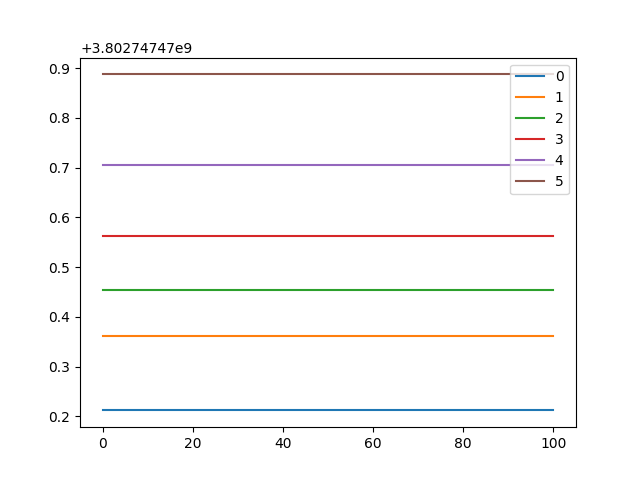

In [69]:
plt.figure()
for k in range(len(vb)):
    V = vb[k][s,0]*X+vb[k][s,1]
    plt.plot(X[i:j]/reservoir.capacity*100,V[i:j],label=f"{k}")#-penalties[i:j,s]
plt.legend()